# Principal Component Analysis with Ristretto

## Eigenvalue and Eigenvector

For a matrix $A \in \mathbb{R}^{m \times n}$, the eigenvectors $v_i$ and eigenvalues $\lambda_i$ are defined as the following

$$Av_i = \lambda_i v_i.$$

## Singular Value Decomposition

For an arbitrary matrix $X \in \mathbb{R}^{m \times n}$ with $m>n$, its singular value decomposition (SVD) is

$$X=U\Sigma V^\top,$$

where $U \in \mathbb{R}^{m \times n}$ and $V  \in \mathbb{R}^{n \times n}$ are both orthogonal matrices,
and $\Sigma = \operatorname{diag}(\sigma_1, \sigma_2, \cdots, \sigma_n)$ with
$\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_n \geq 0$.
The column vector $u_i$ from $U$ is called a left singular vector.
Similarly, the column vector $v_i$ from $V$ is called a right singular vector. The $\sigma_i$ is called a singular value.
Notably, with denoting the $i$th eigenvalue of $AA^\top$ by $\lambda_i$, we have the following:

$$\Sigma = \sqrt{\operatorname{diag}\left(\lambda_1, \lambda_2, \ldots, \lambda_n\right)}$$.

## Principal Component Analysis

In machine learning, it is very common that the data would be high-dimensional.
Though introducing more features could give a more detailed description to the sampled data points,
sometimes there are several cases that a lower-dimensional representation is preferred:

- The features might be highly correlated and the redundancy somehow needs to be removed
- We would like to visualize the data in 2D or 3D
- Reduce the computing cost

Principal Component Analysis (PCA) is a normal way for data dimension reduction,
which can always be produced by doing eigenvalue decomposition on the data's covariance matrix $\Sigma$.
Denote the input data by $X \in \mathbb{R}^{m \times n}$, where each row $x_i$ is an input sample.
Without loss of generality, assume that $X$ is zero-centered
(otherwise it can be easily reached from the raw data by substracting the mean $\bar{x}=\frac{1}{n} \sum_{i=1}^{n}x_i$).
Then, the covariance matrix of $X$ is:

$$\frac{X^\top X}{n-1}.$$

To represent $X$ in a lower dimension, we are looking for the directions of high variance within the data,
which makes them the most representative ones. Given a unit vector $\mathbf{v}$,
the above question can be defined as:

$$
\begin{equation}
\underset{\mathbf{v}_k}{\arg\max} \, \, \frac{1}{n} \sum_{i=1}^{n}\left( x_{i}^{\top} \mathbf{v}\right)^{2} = \underset{\mathbf{v}_k}{\arg\max} \, \, \mathbf{v}^\top X^\top X \mathbf{v},
\end{equation}
$$

the constraint of which can be removed by computing its Lagrangian as follows,

$$\mathcal{L} = \mathbf{v}^{\top} X^{\top} X \mathbf{v}-\lambda\left(\mathbf{v}^{\top} \mathbf{v}-1\right).$$

And with first order condition, we have

$$X^\top X \mathbf{v} = \lambda \mathbf{v},$$

where by definition, $\lambda$ and $\mathbf{v}$ are respectively the eigenvalue and the corresponding eigenvector of $X^\top X$.
Now we have the 1st principal component. To derive more "valuable" directions from the observed data points,
we define the $k$th principal component direction for $X$ solves:

$$\max_{ \mathbf{v}_k } \operatorname{Var}(X\mathbf{v}_k) = \max_{\mathbf{v}_k} \mathbf{v}_k^{\top} X^{\top} X \mathbf{v}_k$$

$$\mathrm{s.t. }\,\, \mathbf{v}_k^\top \mathbf{v}_k = 1, \  \mathbf{v}_k \mathbf{v}_i = 0, \ i=1, 2, \cdots, k-1.$$

Here $\mathbf{v}_k$ is claim that vk is a unit eigenvector of $X^\top X$ corresponding to its $k$th largest eigenvalue,
which can be proved by induction.
Let $X=U\Sigma V^\top$ be the SVD of $X$, then the columns of $U\Sigma$ are called the principal components.

With the above material, we come to a conclusion that the loading vectors of $X$ are its right singular vectors,
i.e. $\mathbf{v}_i$ is the $i$th column of $V$.
Note that by the definition of SVD, we can obtain $k$ principal components $Z_k$ by computing:

$$Z_k = XV_k = U\Sigma V^\top V = U\Sigma.$$

To demonstrate PCA, we will apply the routines from Ristretto on Face Eigen dataset to produce the result.

In [3]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from time import time
import matplotlib.pyplot as plt
import ristretto.pca as ris_pca

# Prepare the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
X -= np.mean(X, axis=0)
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

# Calling the routine from SKLearn
t0 = time()
pca = PCA(n_components=n_components, svd_solver='full',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

# The one from Ristretto
t0 = time()
pca_ris = ris_pca.PCA(n_components=n_components, svd_type='original').fit(X_train)
X_train_pca_ris = pca_ris.transform(X_train)

X_test_pca_ris = pca_ris.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.109s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.007s
done in 0.114s


Fitting the classifier to the training set
done in 25.199s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
done in 0.039s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.88      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  1   2  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]

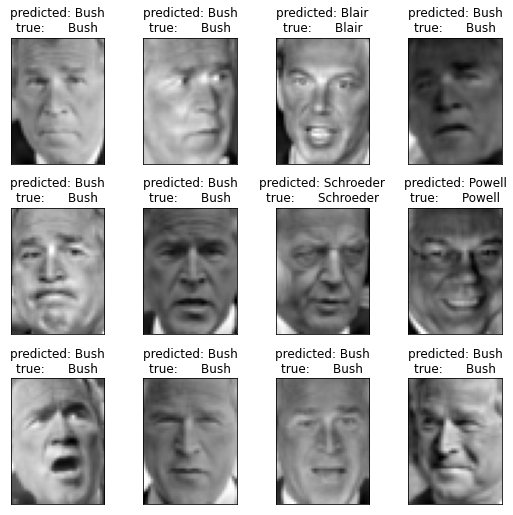

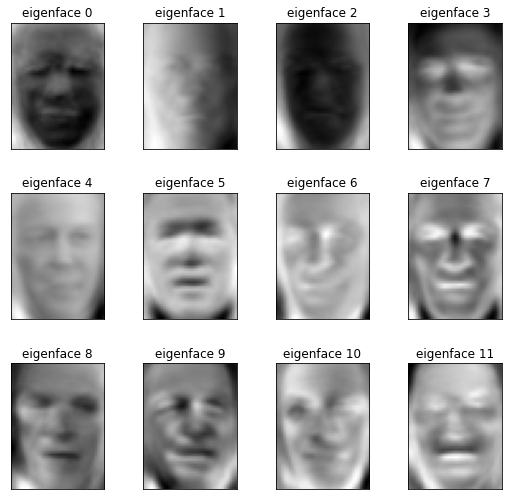

In [2]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca_ris, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

t0 = time()
y_pred = clf.predict(X_test_pca_ris)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()